In [124]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision as transforms,datasets
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# GPU check
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [125]:
from torchvision import transforms, datasets
import torch
from torch.utils.data import DataLoader

# CIFAR-100 mean & std
mean = [0.5071, 0.4867, 0.4408]
std  = [0.2675, 0.2565, 0.2761]

# Train transforms
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)  # <- THIS WAS MISSING
])

# Test transforms
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)  # <- THIS WAS MISSING
])

# Dataset & DataLoader
train_data = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
test_data = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)


In [126]:
print(train_data[0][1])  # should print an integer between 0–99


19


In [127]:
import torch.nn as nn
import torch.nn.functional as F

In [128]:
class MasterCNN(nn.Module):
        def __init__(self,num_class=100):
            super(MasterCNN,self).__init__()
    
            #block-1
            self.conv1=nn.Conv2d(3,64,3,1,padding=1)
            self.bn1=nn.BatchNorm2d(64)
            self.conv2=nn.Conv2d(64,64,3,1,padding=1)
            self.bn2=nn.BatchNorm2d(64)
            self.pool1=nn.MaxPool2d(2,2)
            self.drop1=nn.Dropout(0.25)
    
    
            #Block-2
    
            self.conv3=nn.Conv2d(64,128,3,1,padding=1)
            self.bn3=nn.BatchNorm2d(128)
            self.conv4=nn.Conv2d(128,128,3,1,padding=1)
            self.bn4=nn.BatchNorm2d(128)
            self.pool2=nn.MaxPool2d(2,2)
            self.drop2=nn.Dropout(0.25)
    
    
    
            #Block-3
    
            self.conv5=nn.Conv2d(128,256,3,1,padding=1)
            self.bn5=nn.BatchNorm2d(256)
            self.conv6=nn.Conv2d(256,256,3,1,padding=1)
            self.bn6=nn.BatchNorm2d(256)
            self.pool3=nn.MaxPool2d(2,2)
            self.drop3=nn.Dropout(0.25)
    
           
    
            #Fully Connected layers
    
            self.fc1 = nn.Linear(256*4*4, 512)
            self.bn_fc1 = nn.BatchNorm1d(512)
            self.drop_fc1 = nn.Dropout(0.5)
            self.fc2 = nn.Linear(512, num_class)

        



        def forward(self,x):
            #block
            x=F.relu(self.bn1(self.conv1(x)))
            x=F.relu(self.bn2(self.conv2(x)))
            x=self.pool1(x)
            x=self.drop1(x)



            #block

            x=F.relu(self.bn3(self.conv3(x)))
            x=F.relu(self.bn4(self.conv4(x)))
            x=self.pool2(x)
            x=self.drop2(x)


            #block-3

            x=F.relu(self.bn5(self.conv5(x)))
            x=F.relu(self.bn6(self.conv6(x)))
            x=self.pool3(x)
            x=self.drop3(x)


            #Flatten

            x=x.view(x.size(0),-1)


            #fully connected

            x=F.relu(self.bn_fc1(self.fc1(x)))
            x=self.drop_fc1(x)
            x=self.fc2(x)


            return x




        

        



In [129]:
model = MasterCNN().to(device)
print(model)

MasterCNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout(p=0.25, inplace=False)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), pa

In [130]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MasterCNN(num_class=100).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50  
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    train_loss /= len(train_loader.dataset)
    train_acc = 100. * correct / total
    
    # Validation
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    val_loss /= len(test_loader.dataset)
    val_acc = 100. * correct / total
    
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")


Epoch [1/50] Train Loss: 3.6793, Train Acc: 13.50% | Val Loss: 3.1307, Val Acc: 23.24%
Epoch [2/50] Train Loss: 2.8794, Train Acc: 26.93% | Val Loss: 2.4654, Val Acc: 36.01%
Epoch [3/50] Train Loss: 2.5057, Train Acc: 34.58% | Val Loss: 2.2047, Val Acc: 40.79%
Epoch [4/50] Train Loss: 2.2893, Train Acc: 39.19% | Val Loss: 2.0226, Val Acc: 45.41%
Epoch [5/50] Train Loss: 2.1254, Train Acc: 42.88% | Val Loss: 1.7989, Val Acc: 50.34%
Epoch [6/50] Train Loss: 2.0061, Train Acc: 45.56% | Val Loss: 1.7517, Val Acc: 51.52%
Epoch [7/50] Train Loss: 1.9066, Train Acc: 47.61% | Val Loss: 1.6675, Val Acc: 53.57%
Epoch [8/50] Train Loss: 1.8249, Train Acc: 49.70% | Val Loss: 1.5835, Val Acc: 55.39%
Epoch [9/50] Train Loss: 1.7452, Train Acc: 51.43% | Val Loss: 1.5071, Val Acc: 57.38%
Epoch [10/50] Train Loss: 1.6792, Train Acc: 52.91% | Val Loss: 1.5345, Val Acc: 57.18%
Epoch [11/50] Train Loss: 1.6191, Train Acc: 54.64% | Val Loss: 1.4849, Val Acc: 57.79%
Epoch [12/50] Train Loss: 1.5687, Train A

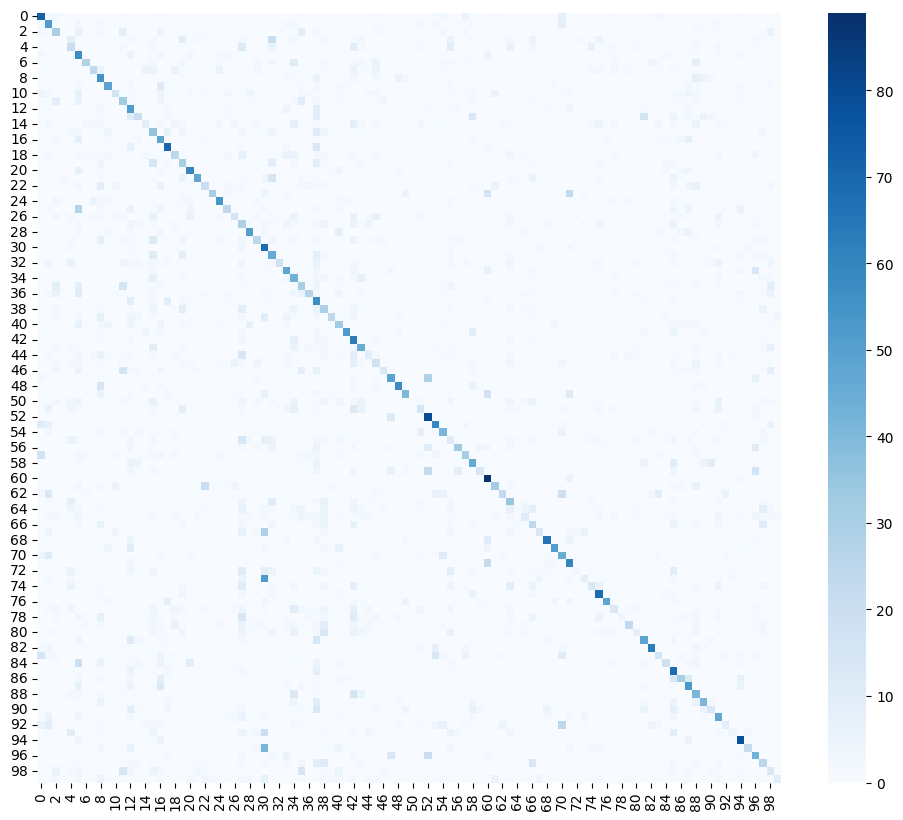

In [132]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = outputs.max(1)
        all_labels.extend(labels.numpy())
        all_preds.extend(preds.cpu().numpy())

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=False, cmap="Blues")
plt.show()


In [133]:
torch.save(model.state_dict(), "master_cnn_cifar100.pth")
